# Residue Constants

Distances:
- ca - ca ✓
- c - o ✓
- c - n ✓
- n - h - no H atoms in samples

Angles:
- n - ca - c ✓
- ca - c - o ✓
- ca - c - n ✓
- c - n - ca ✓
- c - n - h - no H atoms in samples

In [27]:
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os

from collections import defaultdict
from poc.analysis.af_residue_constants import rigid_group_atom_positions

## Sample Files

In [28]:
data_dir = 'data'
transformed_data = data_dir + '/transformed.json'
if os.path.exists(transformed_data):
    os.remove(transformed_data)
samples = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
samples = [sample for sample in samples if '.DS_Store' not in sample]
samples

['data/3cln.cif',
 'data/2bl2.cif',
 'data/8zts.cif',
 'data/4hhb.cif',
 'data/8xnj.cif',
 'data/1stp.cif',
 'data/4ake.cif',
 'data/2hhb.cif',
 'data/9f2a.cif',
 'data/5t4p.cif',
 'data/6m17.cif',
 'data/9jwd.cif',
 'data/1a4y.cif',
 'data/9h44.cif',
 'data/8ykn.cif']

## Process files to new format

In [29]:
amino_acids = []
for sample in samples:
    with open(sample, 'r') as f:
        chain_before = None
        seq_id_before = None
        current_aa = []
        current_chain = defaultdict(list)
        for line in f:
            data = line.strip().split()
            if data[0] != 'ATOM': continue
            seq_id = data[8]
            chain = data[18]
            if chain != chain_before and chain_before is not None:
                amino_acids.append(*current_chain.values())
                current_chain = defaultdict(list)
            if seq_id != seq_id_before and seq_id_before is not None:
                current_chain[chain].append(current_aa)
                current_aa = []
            aa = data[5]
            atom_id = data[3]
            x = float(data[10])
            y = float(data[11])
            z = float(data[12])
            if len(current_aa) == 0:
                current_aa.append(data[5])
            current_aa.append((atom_id, x, y, z))
            chain_before = chain
            seq_id_before = seq_id
        amino_acids.append(*current_chain.values())

with open(transformed_data, 'w') as f:
    json.dump(amino_acids, f, indent=4)

In [58]:
# utility function
def bplot_data_with_stats(data, title: str, label: str, fn: str):
    plt.boxplot(data, vert=False)

    handles = [
        plt.Line2D([0], [0], color='blue', label=f"Mean: {np.mean(data):.10f}"),
        plt.Line2D([0], [0], color='orange', label=f"Median: {np.median(data):.10f}"),
    ]
    plt.legend(handles=handles, loc='upper right')

    plt.title(title)
    plt.xlabel(label)
    plt.savefig(f"plt/{fn}.png", dpi=600)
    plt.show()

## Data stats

In [ ]:
disassembled_acids = defaultdict(int)
for chain in amino_acids:
    for aa in chain:
        disassembled_acids[aa[0]] += 1

total = sum(disassembled_acids.values())
plt.figure(figsize=(10, 6))
plt.bar(disassembled_acids.keys(), list(disassembled_acids.values()), width=0.4)
plt.show()

print('Total analyzed amino acids:', total)


### Alpha Folds Measurements

In [33]:
af_rigid_atom_positions = defaultdict(lambda: defaultdict(float))
for aa, atoms in rigid_group_atom_positions.items():
    for atom in atoms:
        af_rigid_atom_positions[aa][atom[0]] = math.sqrt(atom[2][0]**2 + atom[2][1]**2 + atom[2][2]**2)

## Params

In [34]:
percentile_cut = 0.05

### Ca - Ca distance

In [35]:
ca_ca_distances = []
# af_ca_ca = 3.80209737096
for chain in amino_acids:
    ca_before = None
    for aa in chain:
        for atom in aa[1:]:
            if atom[0] != 'CA': continue
            if ca_before is None:
                ca_before = atom
                continue
            ca_ca_distances.append(
                math.sqrt(
                    (ca_before[1]-atom[1])**2 + (ca_before[2]-atom[2])**2 + (ca_before[3]-atom[3])**2
                )
            )
            ca_before = atom

perc = int(len(ca_ca_distances) * percentile_cut)
ca_ca_distances = np.array(sorted(ca_ca_distances)[perc:-perc])
# ca_ca_distances = np.array(ca_ca_distances)

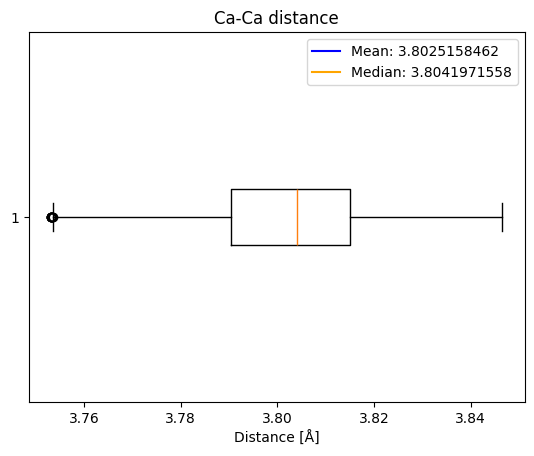

In [59]:
bplot_data_with_stats(ca_ca_distances, 'Ca-Ca distance', 'Distance [Å]', 'distance_ca_ca')

### C - O distance

In [ ]:
c_o_distances = []
for chain in amino_acids:
    for aa in chain:
        c = next(atom for atom in aa[1:] if atom[0] == 'C')
        o = next(atom for atom in aa[1:] if atom[0] == 'O')

        c_o_distances.append(
            math.sqrt(
                (c[1]-o[1])**2 + (c[2]-o[2])**2 + (c[3]-o[3])**2
            )
        )

perc = int(len(c_o_distances) * percentile_cut)
c_o_distances = np.array(sorted(c_o_distances)[perc:-perc])

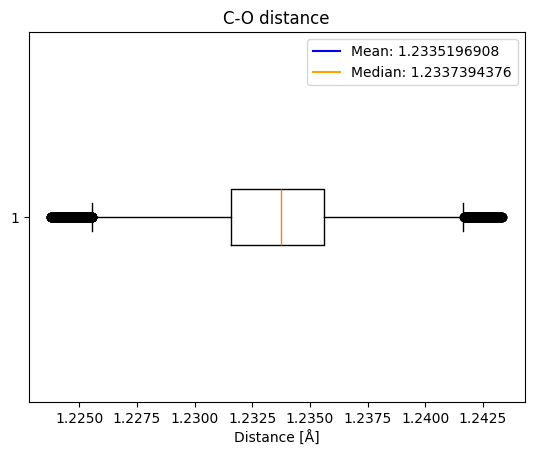

In [60]:
bplot_data_with_stats(c_o_distances, 'C-O distance', 'Distance [Å]', 'distance_c_o')

### C - N distance

In [39]:
c_n_distances = []
for chain in amino_acids:
    c_before = None
    for aa in chain:
        for atom in aa[1:]:
            if atom[0] not in ['C', 'N']: continue
            if c_before is None and atom[0] == 'C':
                c_before = atom
                continue
            if c_before is not None and atom[0] == 'N':
                c_n_distances.append(
                    math.sqrt(
                         (c_before[1]-atom[1])**2 + (c_before[2]-atom[2])**2 + (c_before[3]-atom[3])**2
                    )
                )
                c_before = None

perc = int(len(c_n_distances) * percentile_cut)
c_n_distances = np.array(sorted(c_n_distances)[perc:-perc])

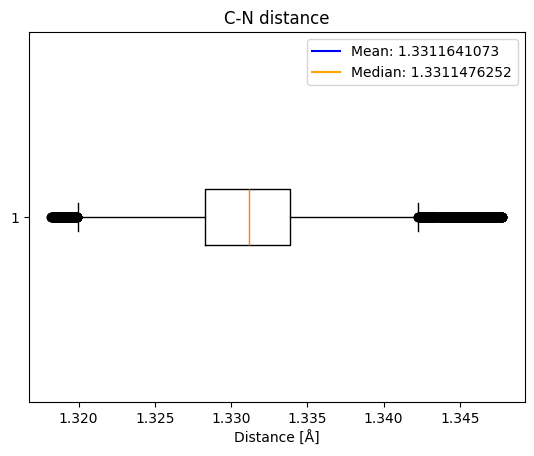

In [61]:
bplot_data_with_stats(c_n_distances, 'C-N distance', 'Distance [Å]', 'distance_c_n')

## Angles

In [41]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def calculate_angle(p1, p2, p3):
    # print('p1', p1)
    # print('p2', p2)
    # print('p3', p3)
    v1 = p1 - p2
    v2 = p3 - p2
    v1_u = v1 / np.linalg.norm(v1)
    v2_u = v2 / np.linalg.norm(v2)
    # print('v1', v1, v1_u)
    # print('v2', v2, v2_u)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

The first two angles are completely within one amino acid, so the data is processed accordingly.

In [42]:
aas = defaultdict(list)
for chain in amino_acids:
    for aa in chain:
        aas[aa[0]].append(aa[1:])


In [43]:
def get_data_for_angle(a1: str, a2: str, a3: str) -> np.array:
    angles = []
    for key, values in aas.items():
        for aa in values:
            n = next(atom for atom in aa if atom[0] == a1)
            ca = next(atom for atom in aa if atom[0] == a2)
            c = next(atom for atom in aa if atom[0] == a3)
            angle = calculate_angle(np.array(n[1:]), np.array(ca[1:]), np.array(c[1:]))
            angles.append(angle)

    perc = int(len(angles) * percentile_cut)
    return np.array(sorted(angles)[perc:-perc])


### N - Ca - C


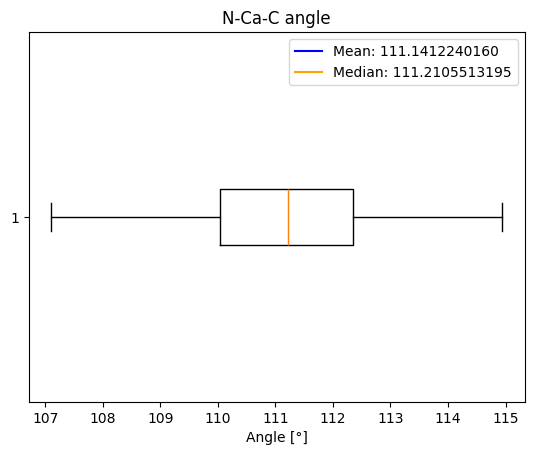

In [62]:
bplot_data_with_stats(get_data_for_angle('N', 'CA', 'C'), 'N-Ca-C angle', 'Angle [°]', 'angle_n_ca_c')

### Ca - C - O

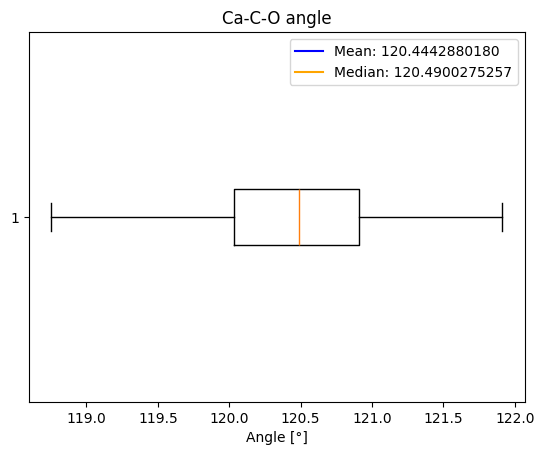

In [63]:
bplot_data_with_stats(get_data_for_angle('CA', 'C', 'O'), 'Ca-C-O angle', 'Angle [°]', 'angle_ca_c_o')

### Ca - C - N

In [46]:
ca_c_n_angles = []
for chain in amino_acids:
    for i in range(len(chain) - 1):
        res1 = chain[i]
        res2 = chain[i + 1]
        ca = next(atom for atom in res1[1:] if atom[0] == 'CA')
        c  = next(atom for atom in res1[1:] if atom[0] == 'C')
        n  = next(atom for atom in res2[1:] if atom[0] == 'N')
        ca_c_n_angles.append(calculate_angle(np.array(ca[1:]), np.array(c[1:]), np.array(n[1:])))
perc = int(len(ca_c_n_angles) * percentile_cut)
ca_c_n_angles = np.array(sorted(ca_c_n_angles)[perc:-perc])

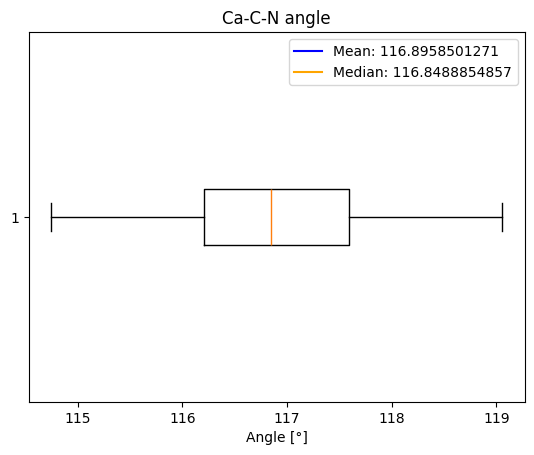

In [64]:
bplot_data_with_stats(ca_c_n_angles, 'Ca-C-N angle', 'Angle [°]', 'angle_ca_c_n')

### C - N - CA

In [48]:
c_n_ca_angles = []
for chain in amino_acids:
    for i in range(len(chain) - 1):
        res1 = chain[i]
        res2 = chain[i + 1]
        ca = next(atom for atom in res1[1:] if atom[0] == 'C')
        c  = next(atom for atom in res2[1:] if atom[0] == 'N')
        n  = next(atom for atom in res2[1:] if atom[0] == 'CA')
        c_n_ca_angles.append(calculate_angle(np.array(ca[1:]), np.array(c[1:]), np.array(n[1:])))
perc = int(len(c_n_ca_angles) * percentile_cut)
c_n_ca_angles = np.array(sorted(c_n_ca_angles)[perc:-perc])

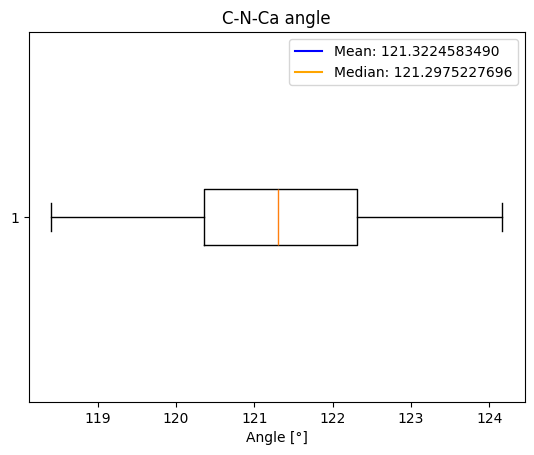

In [65]:
bplot_data_with_stats(c_n_ca_angles, 'C-N-Ca angle', 'Angle [°]', 'angle_c_n_ca')